<a href="https://colab.research.google.com/github/zhus-dika/railways_caclulations/blob/main/regression_arma_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐫 Realize regression model

## 🦀 Download data

### 🪰 Install need packages

In [2]:
# ! apt install x13as
! pip install pyexcel pyexcel-xls pyexcel-xlsx

### 🐳 Imports

In [3]:
import pandas as pd
import statsmodels.api as sm
import gdown
from datetime import datetime
import math
import numpy as np

import seaborn as sns

from openpyxl import load_workbook
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import itertools
import statsmodels.api as sm

### 🦥 Constants

In [4]:
selected_types = ['Coal', 'Petrol', 'Scrap', 'Chem', 'Fert', 'nFerr', 'Iron']

### 🐻‍❄️ Useful methods

In [5]:
def construct_serial_data_by_type(type, df, dct_serial):
  dates = [datetime.strptime(i, '%y-%m') for i in df.columns]
  serial_dates = {i: [] for i in dct_serial[type]}
  for idx, date in enumerate(dates):
    for key, value in serial_dates.items():
      dt = datetime.strptime(key[3:5]+'-'+key[-2:], '%y-%m')
      if date == dt:
        serial_dates[key].append(1)
      else:
        serial_dates[key].append(0)
  return serial_dates

In [6]:
start = 2002
end = 2024

def excel_columns(n):
    columns = []
    for i in range(1, n + 1):
        col = ""
        num = i
        while num > 0:
            num -= 1
            col = chr(65 + (num % 26)) + col
            num //= 26
        columns.append(col)
    return columns

column_names = excel_columns(14 * (end - start + 1))

In [7]:
def fill_transportation_tariffs(table_data, start, end):
  commodities_transportation_tariffs = {datetime.strptime(str(year) + '-' + str(i), '%Y-%m').strftime("%y-%m"): [] for year in range(start, end + 1) for i in range(1, 13)}
  commodities_transportation_tariffs['name'] = []
  name_column = 'A'
  for i in range(1, 82):
    if i % 4 == 0:
      value = table_data[name_column+str(i)].value
      value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').replace("\n", " ").lower()
      name = " ".join(value.split())
      commodities_transportation_tariffs['name'].append(name)

      for column_num in range((end - start + 1) * 12):
        val_volume = table_data[column_names[column_num + 2 + math.floor(column_num / 12)] + str(i + 1)].value
        commodities_transportation_tariffs[datetime.strptime(str(start + math.floor(column_num / 12))  + '-' + str(column_num % 12 + 1), '%Y-%m').strftime("%y-%m")].append(val_volume)
  return commodities_transportation_tariffs

In [8]:
def plot_regression_results(model, df):
  df["fitted"] = model.fittedvalues
  df["residuals"] = model.resid

  # Plot of actual, predicted, and residual values
  fig, ax1 = plt.subplots(figsize=(20, 10))

  # Actual and predicted lines
  ax1.plot(df.index, df["V_SA"], color="red", label="Actual")
  ax1.plot(df.index, df["fitted"], color="green", label="Fitted")

  # Second axis for residuals
  ax2 = ax1.twinx()
  ax2.plot(df.index, df["residuals"], color="blue", label="Residual", alpha=0.7)

  # Add a horizontal line at level 0 for residuals
  ax2.axhline(0, linestyle="--", color="black", linewidth=0.8)

  ax1.legend(loc="upper right")
  ax2.legend(loc="lower right")

  # Axis titles
  ax1.set_xlabel("Date")
  ax1.set_ylabel("Actual & Fitted")
  ax2.set_ylabel("Residuals")


  step = max(10, len(df.columns))  # Количество подписей по X не больше 10

  ax1.set_xticks(df.index[::step])
  ax1.set_xticklabels(df.index[::step], rotation=45, fontsize=11)  # Красиво форматируем

  ax2.set_xticks(df.index[::step])
  ax2.set_xticklabels(df.index[::step], rotation=45, fontsize=11)  # Красиво форматируем
  #ax1.set_xticklabels(ax1.get_xticks(), rotation = 45, fontsize=6)
  plt.title("Actual, Fitted, and Residuals Plot")
  plt.show()

## 🐟 Read data

### 🐺 Getting indexed adjustment volumes data

In [9]:
url = "https://drive.google.com/uc?id=1nv0pPe2E1NQRzZF-pHHZkTT71CTHc68R"
volumes = 'volumes.xlsx'
gdown.download(url, volumes, quiet=False);


df_volumes = pd.read_excel('volumes.xlsx', index_col='type')

Downloading...
From: https://drive.google.com/uc?id=1nv0pPe2E1NQRzZF-pHHZkTT71CTHc68R
To: /content/volumes.xlsx
100%|██████████| 107k/107k [00:00<00:00, 61.2MB/s]


In [10]:
df_volumes = df_volumes.rename(columns={date: date.strftime('%y-%m') for date in df_volumes.columns})

In [11]:
df_volumes.sample(5)

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
type,,,,,,,,,,,,,,,,,,,,,
Coke_adjusted,1.038652,1.006180,0.993246,0.988889,0.986890,1.026394,0.998445,0.997933,1.003222,0.987501,...,1.208424,1.221924,1.667015,1.185833,1.046100,1.077373,1.053056,1.105203,1.444303,1.190871
Chem,0.781912,0.954545,0.955041,0.315829,0.734597,0.912752,0.540889,1.014799,1.145083,1.400219,...,1.144269,1.109723,1.124065,1.248496,0.824994,1.012949,1.102872,1.092838,1.350000,1.094862
Coal,1.149409,1.127601,1.534823,1.554613,1.244032,1.396526,1.146947,0.862378,0.858023,1.048863,...,0.949497,0.903377,0.885861,0.863684,0.989411,0.991784,1.039864,0.997572,1.069246,1.043178
Oil,1.115174,1.136405,1.091621,1.078433,1.158262,1.124876,1.004544,0.968246,1.034343,1.070271,...,0.989706,0.962414,0.937851,0.993148,1.047081,1.015890,1.017763,0.808824,0.941992,0.902337
Cement_adjusted,1.147336,1.102376,0.892257,0.905910,1.308594,1.430011,1.325809,1.229607,1.270885,1.222293,...,0.818200,1.018180,0.966344,0.968121,1.033922,1.064140,1.089983,0.983672,0.948599,1.083497


🦐 Filter only adjusted rows

In [12]:
adjusted_rows = [i for i in df_volumes.index if len(i.split('_')) > 1]

mask = df_volumes.index.isin(adjusted_rows)
df_volumes = df_volumes[mask]

In [13]:
df_volumes.sample(5)

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
type,,,,,,,,,,,,,,,,,,,,,
Oil_adjusted,1.114516,1.124344,1.086534,1.077561,1.160076,1.115107,1.015461,0.994196,1.027111,1.063774,...,0.996553,0.978653,0.955117,0.973056,1.025939,0.997069,1.022066,0.814616,0.927846,0.905966
Drinks_adjusted,1.058928,1.010184,1.019816,1.107321,1.055743,1.131114,1.126587,1.173688,1.274232,1.168759,...,0.983818,1.005387,1.021985,1.021990,1.050561,1.015551,1.034032,1.077381,1.032528,1.125397
Wheat_adjusted,1.405050,1.335464,1.243198,1.222072,1.201595,1.164400,1.046377,0.921651,0.984873,0.996572,...,0.984923,0.906323,1.012457,1.108902,0.909788,1.013309,1.064729,1.063984,0.962319,1.089922
Iron_adjusted,1.196323,1.137040,1.090749,1.076335,1.193487,1.106854,1.280330,1.251372,1.314330,1.248365,...,1.350003,1.142641,1.207504,1.233599,1.122828,1.392767,1.229503,1.179020,1.171365,0.987085
Scrap_adjusted,0.936710,1.089962,0.995131,0.954440,1.143378,1.087669,1.101920,1.097321,1.110280,0.879515,...,1.120680,1.124807,1.641127,2.651149,1.201098,0.866250,1.035905,0.902910,1.205425,1.141718


In [14]:
df_volumes.index = [i.split('_')[0] for i in df_volumes.index]

In [15]:
df_volumes.sample(5)

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
Wheat,1.405050,1.335464,1.243198,1.222072,1.201595,1.164400,1.046377,0.921651,0.984873,0.996572,...,0.984923,0.906323,1.012457,1.108902,0.909788,1.013309,1.064729,1.063984,0.962319,1.089922
Petrol,1.174994,1.408839,1.107679,1.372890,1.628618,1.181692,1.053518,1.236957,1.099171,0.943648,...,1.056319,0.776202,0.985852,0.997361,1.315673,1.006776,1.008240,1.045294,1.066065,1.094943
Coal,1.196102,1.131517,1.467854,1.571780,1.246030,1.360207,1.149243,0.871470,0.876410,1.035849,...,0.955767,0.913846,0.897452,0.879400,0.988293,1.004901,1.039385,0.988534,1.057211,1.042360
Cement,1.147336,1.102376,0.892257,0.905910,1.308594,1.430011,1.325809,1.229607,1.270885,1.222293,...,0.818200,1.018180,0.966344,0.968121,1.033922,1.064140,1.089983,0.983672,0.948599,1.083497
Drinks,1.058928,1.010184,1.019816,1.107321,1.055743,1.131114,1.126587,1.173688,1.274232,1.168759,...,0.983818,1.005387,1.021985,1.021990,1.050561,1.015551,1.034032,1.077381,1.032528,1.125397


🐹 Plot volumes

In [16]:
# fig, axes = plt.subplots(len(df_volumes), 1, figsize=(38, 4.8 * len(df_volumes)), sharex=False)

# for ax, cargo in zip(axes, df_volumes.index):
#     ax.plot(df_volumes.columns, df_volumes.loc[cargo], marker="o", label=cargo)
#     ax.set_title(cargo)
#     ax.grid()
#     ax.legend()

#     step = 1#max(1, len(df_transportation_volumes.columns))  # Количество подписей по X не больше 10
#     ax.set_xticks(df_volumes.columns[::step])
#     ax.set_xticklabels(df_volumes.columns[::step], rotation=45, fontsize=5)  # Красиво форматируем

# plt.xlabel("Дата")
# plt.show()

### 🐤 Getting indexed adjustment transportation volumes data

In [17]:
url = "https://drive.google.com/uc?id=1DL9g_qsXoN82Jgfy2opI1EVSJmE3rHqm"
transportation_volumes = 'transportation_volumes.xlsx'
gdown.download(url, transportation_volumes, quiet=False);


df_transportation_volumes = pd.read_excel(transportation_volumes, index_col='type')

Downloading...
From: https://drive.google.com/uc?id=1DL9g_qsXoN82Jgfy2opI1EVSJmE3rHqm
To: /content/transportation_volumes.xlsx
100%|██████████| 71.0k/71.0k [00:00<00:00, 22.1MB/s]


In [18]:
df_transportation_volumes = df_transportation_volumes.rename(columns={date: date.strftime('%y-%m') for date in df_transportation_volumes.columns})

In [19]:
df_transportation_volumes.head()

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
type,,,,,,,,,,,,,,,,,,,,,
Coal,1.146989,1.271296,2.001057,1.617007,1.497430,2.758001,1.602998,0.851024,0.779384,0.822710,...,0.878720,1.096500,1.038759,0.883244,0.927998,0.906847,1.023522,0.953651,0.927396,1.114861
Iron,1.412507,1.134848,1.154288,1.236893,1.152850,1.289855,1.010562,1.016424,1.126092,1.041267,...,0.743911,0.960014,0.946524,0.947818,0.940809,0.750778,0.922176,0.787614,1.041312,1.086095
Oil,1.001428,0.888155,0.881444,1.181056,1.216150,0.812597,0.862972,0.754016,0.798269,0.892205,...,15.636156,12.682794,12.677791,10.537268,23.466271,14.472157,8.978876,9.888079,12.936303,14.952227
Petrol,1.284108,1.637060,1.612777,1.293651,1.817554,1.618301,1.407716,1.418118,1.159494,1.268705,...,1.089231,1.097304,1.135993,0.915309,0.828344,1.044175,1.052666,0.764055,0.842165,0.945983
Scrap,0.678691,0.532579,1.807040,1.914268,1.586697,0.737438,1.703007,0.809680,1.254796,0.951983,...,0.202896,0.310825,0.237324,0.232234,0.292354,0.323055,0.244754,0.165120,0.099274,0.386449


In [20]:
df_volumes = df_volumes[df_transportation_volumes.columns]
df_volumes.sample(5)

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
Drinks,1.058928,1.010184,1.019816,1.107321,1.055743,1.131114,1.126587,1.173688,1.274232,1.168759,...,0.983818,1.005387,1.021985,1.021990,1.050561,1.015551,1.034032,1.077381,1.032528,1.125397
Coal,1.196102,1.131517,1.467854,1.571780,1.246030,1.360207,1.149243,0.871470,0.876410,1.035849,...,0.955767,0.913846,0.897452,0.879400,0.988293,1.004901,1.039385,0.988534,1.057211,1.042360
Black,1.107154,1.032615,1.036182,1.121432,0.964139,1.101222,1.080336,1.071287,1.114400,1.020916,...,1.094561,1.033828,1.148415,1.132755,1.118854,1.101313,1.001237,1.074308,1.052041,1.079446
Lim,1.243567,1.161781,1.088058,1.209383,1.083081,1.137478,0.964124,0.961124,1.191410,1.389540,...,1.177135,1.152923,1.039607,0.994984,0.985720,0.917058,0.757069,0.972525,1.116322,1.017416
Coke,1.038652,1.006180,0.993246,0.988889,0.986890,1.026394,0.998445,0.997933,1.003222,0.987501,...,1.208424,1.221924,1.667015,1.185833,1.046100,1.077373,1.053056,1.105203,1.444303,1.190871


🦢 Filter only adjusted rows

In [21]:
adjusted_rows = [i for i in df_transportation_volumes.index if len(i.split('_')) > 1]

mask = df_transportation_volumes.index.isin(adjusted_rows)
df_transportation_volumes = df_transportation_volumes[mask]

In [22]:
df_transportation_volumes.index = [i.split('_')[0] for i in df_transportation_volumes.index]

In [23]:
df_transportation_volumes.sample(5)

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
Chem,1.317898,1.452905,1.710915,1.503562,1.553930,2.306235,2.998584,2.721856,2.702542,2.816523,...,0.997980,1.034720,1.089617,1.009715,0.982342,1.071976,1.104329,1.095684,1.227911,1.027881
Scrap,0.886828,0.585344,1.587355,1.831367,1.557240,0.597325,1.430218,0.868343,1.377291,1.090408,...,0.178885,0.302603,0.245981,0.241703,0.307424,0.368203,0.267666,0.166349,0.084997,0.338922
Petrol,1.281106,1.594053,1.668439,1.356418,1.665315,1.605676,1.454053,1.539522,1.187156,1.219016,...,1.058826,1.065175,1.101064,0.913539,0.824681,1.018674,1.084173,0.754617,0.869534,0.984918
Coal,1.210209,1.280507,1.876262,1.648540,1.527830,2.773168,1.675106,0.855644,0.773540,0.795778,...,0.871809,1.133621,0.976907,0.906235,0.943157,0.926101,1.052821,0.972961,0.946873,1.083843
Fert,0.529486,0.565002,0.222501,0.510929,0.722436,0.547361,1.648042,1.183380,0.800825,1.155442,...,1.375440,1.231664,0.775054,0.332912,0.277259,0.462978,0.687349,1.223603,1.384466,2.137279


🐌 Plot transportation volumes

In [24]:
# fig, axes = plt.subplots(len(df_transportation_volumes), 1, figsize=(38, 4.8 * len(df_transportation_volumes)), sharex=False)

# for ax, cargo in zip(axes, df_transportation_volumes.index):
#     ax.plot(df_transportation_volumes.columns, df_transportation_volumes.loc[cargo], marker="o", label=cargo)
#     ax.set_title(cargo)
#     ax.grid()
#     ax.legend()

#     step = 1#max(1, len(df_transportation_volumes.columns))  # Количество подписей по X не больше 10
#     ax.set_xticks(df_transportation_volumes.columns[::step])
#     ax.set_xticklabels(df_transportation_volumes.columns[::step], rotation=45, fontsize=5)  # Красиво форматируем

# plt.xlabel("Дата")
# plt.show()

### 🐊 Getting indexed adjustment world prices data

In [25]:
url = "https://drive.google.com/uc?id=1a9jJ67D7NGdY-Q5KhyCaAQ7YTGzRXztf"
world_prices = 'world_prices.xlsx'
gdown.download(url, world_prices, quiet=False);

df_world_prices = pd.read_excel(world_prices, index_col='type')

Downloading...
From: https://drive.google.com/uc?id=1a9jJ67D7NGdY-Q5KhyCaAQ7YTGzRXztf
To: /content/world_prices.xlsx
100%|██████████| 26.2k/26.2k [00:00<00:00, 53.9MB/s]


In [26]:
df_world_prices = df_world_prices.rename(columns={date: date.strftime('%y-%m') for date in df_world_prices.columns})

In [27]:
df_world_prices

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
type,,,,,,,,,,,,,,,,,,,,,
Coal,0.910420,0.895018,0.877698,0.865713,0.866977,0.967871,1.051836,1.138202,1.176211,1.122449,...,0.702291,0.694719,0.884908,0.969014,0.978099,0.955114,0.856774,1.031734,1.120643,0.915315
Fert,1.017159,1.065212,1.153134,1.154750,1.166842,1.156018,1.163291,1.119011,1.150806,1.184724,...,0.820177,0.783442,0.832950,1.006068,0.984701,0.892370,0.887433,0.894911,0.990986,1.007215
nFerr,1.192778,1.264540,1.180530,1.091839,1.153190,1.148635,1.156215,1.287185,1.328842,1.400018,...,0.954596,1.017968,1.125171,1.052769,1.004572,1.043852,1.068782,1.155891,1.108773,1.088748
Coal_adjusted,0.962963,0.909960,0.888504,0.847205,0.840678,0.925054,0.993878,1.083593,1.158128,1.156729,...,0.680443,0.719036,0.895836,0.975133,0.978947,0.947554,0.813394,1.017913,1.082100,0.946066
Fert_adjusted,1.053316,1.084912,1.139614,1.142951,1.150161,1.144506,1.153162,1.116617,1.142463,1.173647,...,0.816779,0.799967,0.823795,1.023309,0.986328,0.893193,0.876797,0.898003,1.005640,1.008464
nFerr_adjusted,1.239561,1.281993,1.163228,1.078401,1.124831,1.140122,1.149893,1.268218,1.318555,1.394561,...,0.944875,1.035108,1.127650,1.047356,1.014701,1.027609,1.051365,1.120607,1.102526,1.111067


🦭 Filter only adjusted rows

In [28]:
adjusted_rows = [i for i in df_world_prices.index if len(i.split('_')) > 1]

mask = df_world_prices.index.isin(adjusted_rows)
df_world_prices = df_world_prices[mask]

In [29]:
df_world_prices.index = [i.split('_')[0] for i in df_world_prices.index]

In [30]:
df_world_prices

,03-01,03-02,03-03,03-04,03-05,03-06,03-07,03-08,03-09,03-10,...,24-03,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12
Coal,0.962963,0.909960,0.888504,0.847205,0.840678,0.925054,0.993878,1.083593,1.158128,1.156729,...,0.680443,0.719036,0.895836,0.975133,0.978947,0.947554,0.813394,1.017913,1.082100,0.946066
Fert,1.053316,1.084912,1.139614,1.142951,1.150161,1.144506,1.153162,1.116617,1.142463,1.173647,...,0.816779,0.799967,0.823795,1.023309,0.986328,0.893193,0.876797,0.898003,1.005640,1.008464
nFerr,1.239561,1.281993,1.163228,1.078401,1.124831,1.140122,1.149893,1.268218,1.318555,1.394561,...,0.944875,1.035108,1.127650,1.047356,1.014701,1.027609,1.051365,1.120607,1.102526,1.111067


🕷️ Plot world prices

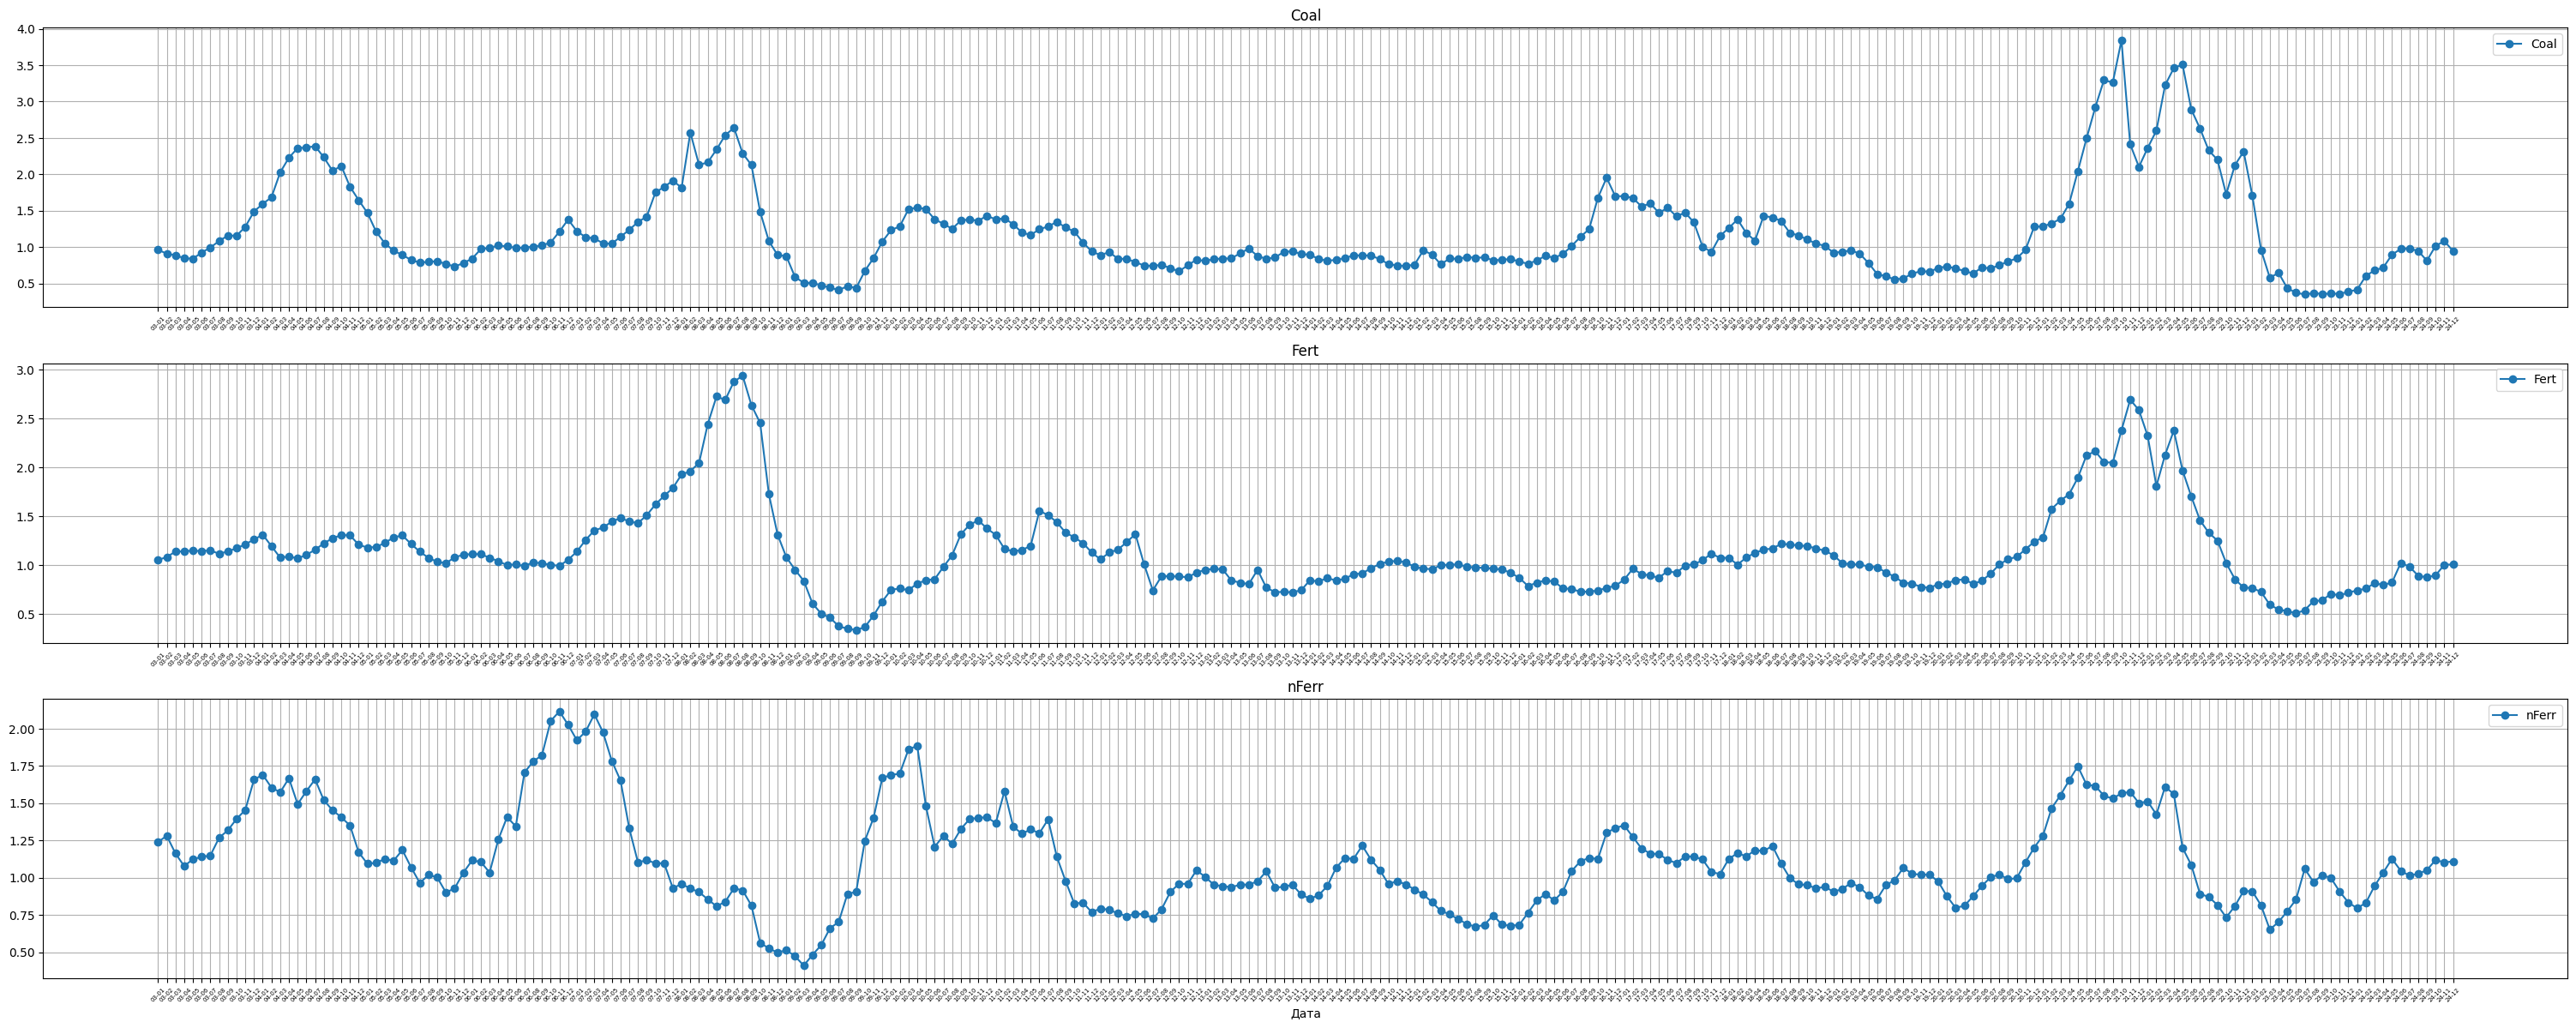

In [31]:
fig, axes = plt.subplots(len(df_world_prices), 1, figsize=(38, 4.8 * len(df_world_prices)), sharex=False)

for ax, cargo in zip(axes, df_world_prices.index):
    ax.plot(df_world_prices.columns, df_world_prices.loc[cargo], marker="o", label=cargo)
    ax.set_title(cargo)
    ax.grid()
    ax.legend()

    step = 1#max(1, len(df_transportation_volumes.columns))  # Количество подписей по X не больше 10
    ax.set_xticks(df_world_prices.columns[::step])
    ax.set_xticklabels(df_world_prices.columns[::step], rotation=45, fontsize=5)  # Красиво форматируем

plt.xlabel("Дата")
plt.show()

🦑 Prepare indexed tariff data

In [32]:
url = "https://drive.google.com/uc?id=1BtFPuxKd6XAhILhfeesl5QnWgZ8o5roO"
tariff = 'tariff.xlsx'
gdown.download(url, tariff, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=1BtFPuxKd6XAhILhfeesl5QnWgZ8o5roO
To: /content/tariff.xlsx
100%|██████████| 2.69M/2.69M [00:00<00:00, 159MB/s]


In [33]:
wb = load_workbook(tariff)

main_sheet = 'Тариф'
commodities_transportation_tariffs = {}

In [34]:
end = 2024
column_names = excel_columns(14 * (end - start + 1))

commodities_transportation_tariffs =  fill_transportation_tariffs(wb[main_sheet], start, end)

In [35]:
df_transportation_tariff = pd.DataFrame(commodities_transportation_tariffs)

In [36]:
df_transportation_tariff.head()

,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,02-10,...,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,уголь
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,железная руда
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,нефть сырая
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,нефтепродукты
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,строительные грузы


In [37]:
dct_names = {'Coal': 'Уголь',
            'Iron': 'Железная руда',
            'Earth': 'Земля, песок, глина и камни природные',
            'Lim': 'Известняк для флюсования',
            'Coke': 'Кокс каменноугольный',
            'Black': 'Чер. металлы',
            'Scrap': 'Лом черных металлов',
            'Wheat': 'Мука пшеничная',
            'Oil': 'Нефть сырая',
            'Petrol': 'Нефтепродукты',
            'Drinks': 'Соки и напитки',
            'Fert': 'Хим. и мин. удобрения',
            'nFerr': 'Цвет. металлы',
            'ColOre': 'Цветная руда',
            'Chem': 'Химикаты и сода',
            'Cement': 'Цемент'
            }

In [38]:
for key in dct_names.keys():
  dct_names[key] = " ".join(dct_names[key].replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').lower().split())

In [39]:
common_names = set(dct_names.keys()) & set(df_volumes.index)

### Select data with common names

In [40]:
df_volumes = df_volumes[df_volumes.index.isin(common_names)]

df_transportation_volumes = df_transportation_volumes[df_transportation_volumes.index.isin(common_names)]

In [41]:
df_transportation_tariff['type'] = ''

for idx, row in df_transportation_tariff.iterrows():
  for key in dct_names.keys():
    if dct_names[key] == row['name']:
      df_transportation_tariff.loc[idx, 'type'] = key

In [42]:
df_transportation_tariff.sample(5)

,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,02-10,...,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,name,type
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,цветная руда,ColOre
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,мука пшеничная,Wheat
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,зерно,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,чер металлы,Black
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,уголь,Coal


In [43]:
df_transportation_tariff = df_transportation_tariff[df_transportation_tariff['type'].isin(common_names)]

In [44]:
df_transportation_tariff.sample(5)

,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,02-10,...,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,name,type
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,нефтепродукты,Petrol
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,хим и мин удобрения,Fert
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,химикаты и сода,Chem
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,мука пшеничная,Wheat
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,кокс каменноугольный,Coke


In [45]:
df_transportation_tariff.set_index('type', inplace=True)

In [46]:
df_transportation_tariff.sample(5)

,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,02-10,...,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,name
type,,,,,,,,,,,,,,,,,,,,,
Oil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,нефть сырая
Earth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,земля песок глина и камни природные
nFerr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,цвет металлы
Petrol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,нефтепродукты
Coal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.8,0.0,0.0,0.0,0.0,0.0,7.8,уголь


🐰 Convert all data 2 float

In [47]:
# for column_num in df_transportation_tariff.columns:
#   if column_num != 'name':
#       df_transportation_tariff.loc[:, column_num] = df_transportation_tariff[column_num].astype(float) / 100 + 1.0
for column_num in df_transportation_tariff.columns:
  if column_num != 'name':
      df_transportation_tariff[column_num] = df_transportation_tariff[column_num].astype(float)
      df_transportation_tariff[column_num] = df_transportation_tariff[column_num] / 100 + 1.0

In [48]:
df_transportation_tariff.sample(5)

,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,02-10,...,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,name
type,,,,,,,,,,,,,,,,,,,,,
Wheat,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,мука пшеничная
Black,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,чер металлы
Coal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,уголь
Lim,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,известняк для флюсования
Oil,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,нефть сырая


🦓 Filter years from 2003

In [49]:
df_transportation_tariff

,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,02-10,...,24-04,24-05,24-06,24-07,24-08,24-09,24-10,24-11,24-12,name
type,,,,,,,,,,,,,,,,,,,,,
Coal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,уголь
Iron,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,железная руда
Oil,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,нефть сырая
Petrol,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,нефтепродукты
Scrap,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,лом черных металлов
Chem,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,химикаты и сода
Fert,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,хим и мин удобрения
ColOre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,цветная руда
nFerr,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.02,...,1.0,1.0,1.088,1.0,1.0,1.0,1.0,1.0,1.078,цвет металлы


In [50]:
df_transportation_tariff = df_transportation_tariff[df_transportation_volumes.columns]

In [51]:
df_transportation_tariff.loc['Coal', '10-01']

1.2153

## 🦚 Run regression model

### 🦤 Prepare data to model

### 🐮 Run all types

In [52]:
import warnings
warnings.filterwarnings("ignore")

### 🦧 Prepare SERial data

In [59]:
dct_serial = {
    #'Coal': ["SER0306", "SER0406", "SER1006", "SER1311", "SER1312", "SER1412", "SER1501", "SER1510", "SER1706"],
    'Coal': ["SER0306", "SER1006"],
    'Iron': ["SER0505", "SER0604", "SER0605", "SER0606", "SER0607", "SER0608", "SER0705", "SER0811", "SER0910", "SER0911", "SER0912", "SER1001", "SER1004", "SER1312", "SER1401", "SER1501", "SER1507", "SER1509", "SER1705", "SER1706", "SER1707"],
    'Oil': ["SER0402", "SER0409", "SER0601", "SER0602", "SER0603", "SER0608", "SER0610", "SER1207", "SER1208", "SER1311", "SER1404", "SER1607", "SER1703", "SER1708"],
    'Petrol': ["SER0405", "SER0510", "SER0706", "SER0912", "SER1009", "SER1212", "SER1401", "SER1501", "SER1505", "SER1603", "SER1604", "SER2206", "SER2401", "SER2407"],
    #'Petrol': ["SER0510", "SER0912", "SER1009", "SER2401"],
    'Constr': ["SER0501", "SER0803", "SER0811", "SER1002", "SER1011", "SER1103", "SER1301", "SER1401", "SER1502", "SER1602", "SER170"],
    'Chem': ["SER0307", "SER0910", "SER0911", "SER1009", "SER1010", "SER1302", "SER1303", "SER2302"],
    #'Chem': ["SER0307", "SER0411", "SER0807", "SER0901", "SER0903", "SER0904", "SER0905", "SER0909", "SER0910", "SER0911", "SER1001", "SER1009", "SER1010", "SER1104", "SER1302", "SER1303", "SER1401", "SER1501", "SER1611", "SER1901", "SER2002", "SER2201", "SER2212", "SER2302"],
    'Black': ["SER0603", "SER1101", "SER1501", "SER1701"],
    'Cement': ["SER0411", "SER0501", "SER0808", "SER1001", "SER1004", "SER1006", "SER1007", "SER1008", "SER1011", "SER1312", "SER1501", "SER1701"],
    'Coke': ["SER0501", "SER0701", "SER0710", "SER0901", "SER1003", "SER1004", "SER1012", "SER1102", "SER1201", "SER1203", "SER1204", "SER1409", "SER1412", "SER1501", "SER1703", "SER1707"],
    'ColOre': ["SER0407", "SER0501", "SER0901", "SER1001", "SER1206", "SER1302", "SER1312", "SER1401", "SER1402", "SER1501", "SER1502", "SER1505", "SER1606"],
    'Corn': ["SER0603", "SER0604", "SER0611", "SER0708", "SER0906", "SER0908", "SER0909", "SER0910", "SER1104", "SER1201", "SER1203", "SER1208", "SER1209", "SER1210", "SER1501", "SER1507"],
    'Drinks': ["SER0401", "SER0508", "SER0701", "SER0801", "SER1009", "SER1104", "SER1306", "SER1312", "SER1401", "SER1501", "SER1509"],
    'Earth': ["SER0401", "SER0503", "SER0704", "SER0710", "SER0812", "SER0903", "SER1002", "SER1101", "SER1301", "SER1401", "SER1403", "SER1501", "SER1503", "SER1505", "SER1701"],
    #'Fert': ["SER0409", "SER0510", "SER0511", "SER0702", "SER0810", "SER1010", "SER1011", "SER1107", "SER1201", "SER1710"],
    'Fert': ["SER0409", "SER0510", "SER0511", "SER0702", "SER0810", "SER1010", "SER1011", "SER1107", "SER1201", "SER1710", "SER1911", "SER2109", "SER2410"],
    'Lim': ["SER0702", "SER1002", "SER1003", "SER1010", "SER1011", "SER1102", "SER1312", "SER1401", "SER1501", "SER1701", "SER1711"],
    'nFerr': ["SER0405", "SER0406", "SER0511", "SER0602", "SER0603", "SER0704", "SER0709", "SER0806", "SER0810", "SER0906", "SER0912", "SER1001", "SER1004", "SER1005", "SER1207", "SER1401", "SER1405", "SER1412", "SER1501", "SER1504", "SER1601", "SER1709", "SER1710", "SER1712", "SER2107", "SER2111", "SER2212", "SER2307", "SER2312", "SER2404"],
    #'nFerr': ["SER0406","SER0806", "SER0810", "SER0906", "SER1401", "SER1412", "SER1501", "SER1601", "SER2111", "SER2212", "SER2307", "SER2404"],
    'Other': ["SER0912", "SER1007", "SER1012", "SER1312", "SER1401", "SER1501"],
    #'Scrap': ["SER0401", "SER0404", "SER0405", "SER0406", "SER0407", "SER0411", "SER0603", "SER0604", "SER0810", "SER0910", "SER0911", "SER0912", "SER1101", "SER1111", "SER1502", "SER1606", "SER1608", "SER1701", "SER1702", "SER2102", "SER1912", "SER2111", "SER2406"],
    'Scrap': ["SER0401", "SER0411", "SER0911", "SER0912", "SER1111", "SER1502", "SER1606", "SER1608", "SER1701",  "SER2102"],
    'Slag': ["SER0402", "SER0704", "SER0705", "SER0707", "SER0708", "SER0911", "SER1001", "SER1101", "SER1102", "SER1109", "SER1110", "SER1511", "SER1601", "SER1612"],
    'Wheat': ["SER0806", "SER0912", "SER1201", "SER1403"]
}

### 🐀 Coal

**********************************************************************************
commodity type: Coal


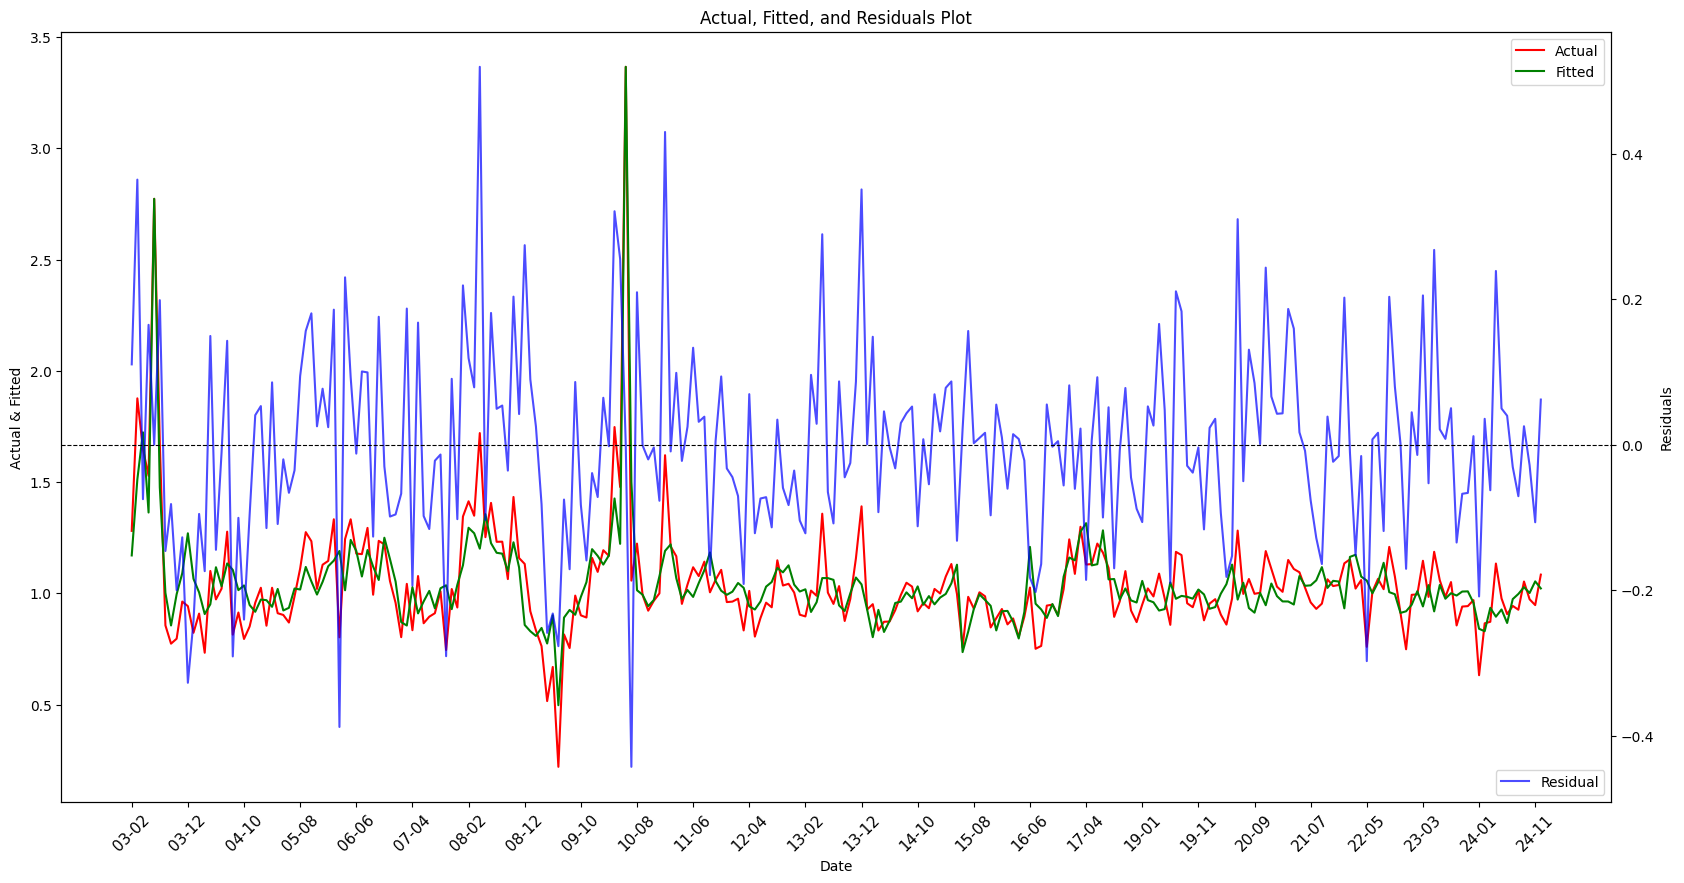

                                 OLS Regression Results                                
Dep. Variable:                   V_SA   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              3024.
Date:                Fri, 21 Feb 2025   Prob (F-statistic):                   2.96e-219
Time:                        11:27:51   Log-Likelihood:                          144.34
No. Observations:                 252   AIC:                                     -278.7
Df Residuals:                     247   BIC:                                     -261.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [74]:
commodity_type = 'Coal'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
    #"P": df_world_prices.loc[commodity_type]   # World prices growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

df_type = df_type.dropna()

Y = df_type["V_SA"]
lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]
df_type.set_index('date', inplace=True)
# Adding a constant for regression
#X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

### 🦊 Petrol

**********************************************************************************
commodity type: Petrol


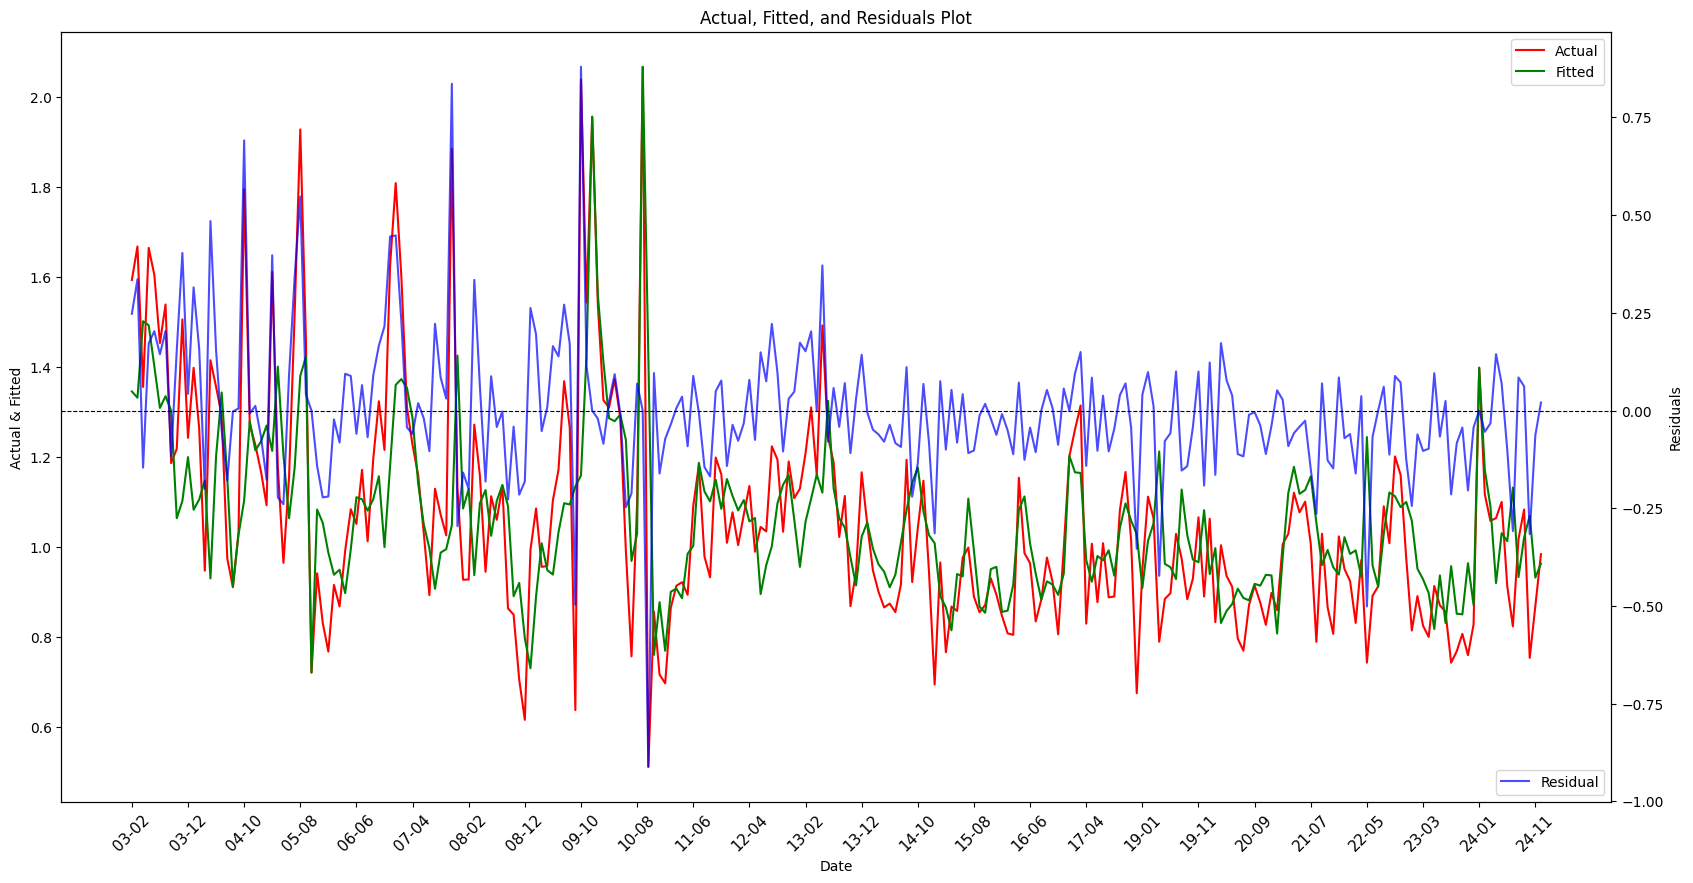

                            OLS Regression Results                            
Dep. Variable:                   V_SA   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     30.50
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           3.84e-30
Time:                        12:03:50   Log-Likelihood:                 65.055
No. Observations:                 252   AIC:                            -114.1
Df Residuals:                     244   BIC:                            -85.87
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4962      0.310      1.603      0.1

In [85]:
commodity_type = 'Petrol'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

df_type = df_type.dropna()

Y = df_type["V_SA"]
lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]
df_type.set_index('date', inplace=True)
# Adding a constant for regression
X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

In [54]:
commodity_type = 'Petrol'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 20)
d_values = range(0, 2)
q_values = range(0, 20)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("T", None)
        pval_T = results.pvalues.get("T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

Не удалось найти подходящую модель, удовлетворяющую условиям.


### 🦡 Scrap

In [ ]:
commodity_type = 'Scrap'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["Y_lag"] = df_type["Y"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["Y"]
X = df_type.drop(columns=["Y"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 10)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("T", None)
        pval_T = results.pvalues.get("T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

Не удалось найти подходящую модель, удовлетворяющую условиям.


### 🦏 Chem

**********************************************************************************
commodity type: Chem


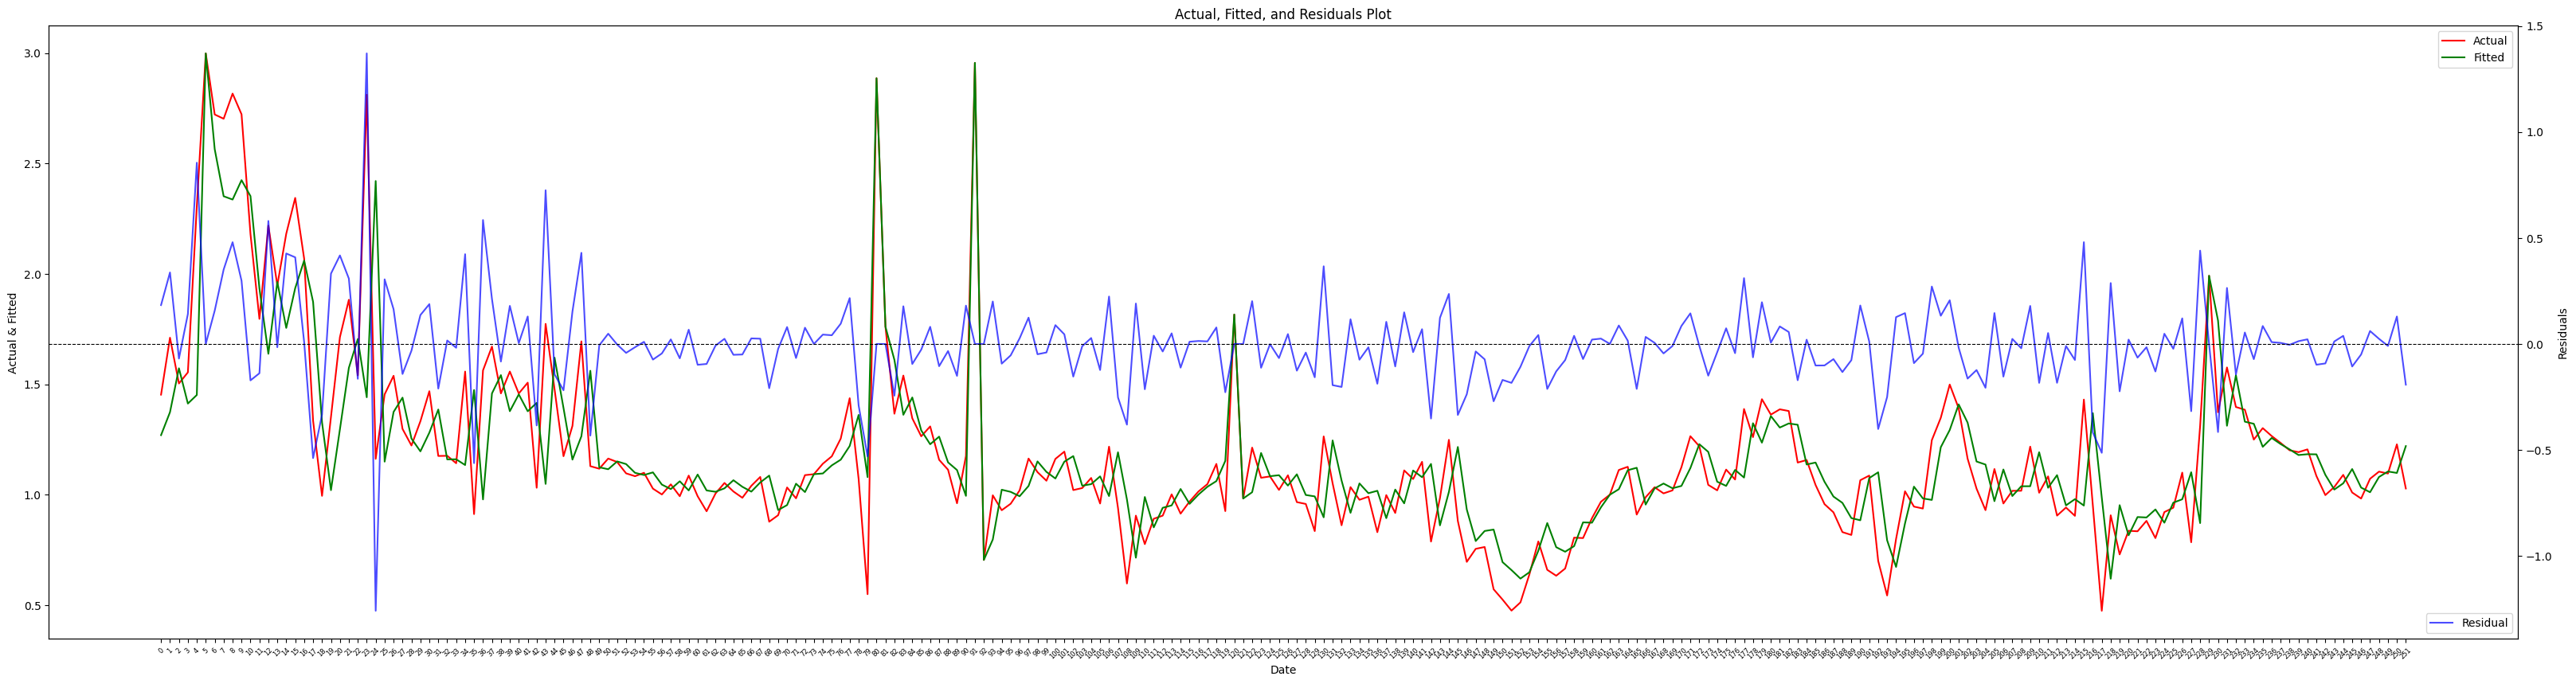

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              695.5
Date:                Fri, 21 Feb 2025   Prob (F-statistic):                   4.54e-172
Time:                        06:31:32   Log-Likelihood:                          11.490
No. Observations:                 252   AIC:                                     -2.979
Df Residuals:                     242   BIC:                                      32.31
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
commodity_type = 'Chem'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    #"X": df_volumes.loc[commodity_type]   # Production growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["Y_lag"] = df_type["Y"].shift(1)

df_type = df_type.dropna()

Y = df_type["Y"]
lst_data = [i for i in df_type.columns if i != 'Y' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]
df_type.set_index('date', inplace=True)
# Adding a constant for regression
#X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

0it [00:00, ?it/s]

Лучшие параметры SARIMAX: (0, 1, 4)
                               SARIMAX Results                                
Dep. Variable:                   V_SA   No. Observations:                  252
Model:               SARIMAX(0, 1, 4)   Log Likelihood                  38.421
Date:                Fri, 21 Feb 2025   AIC                            -44.841
Time:                        13:20:58   BIC                             11.244
Sample:                             0   HQIC                           -22.258
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXP_T         -0.6528      0.335     -1.950      0.051      -1.309       0.003
X              0.0016      0.021      0.077      0.939      -0.039       0.042
SER0307        1

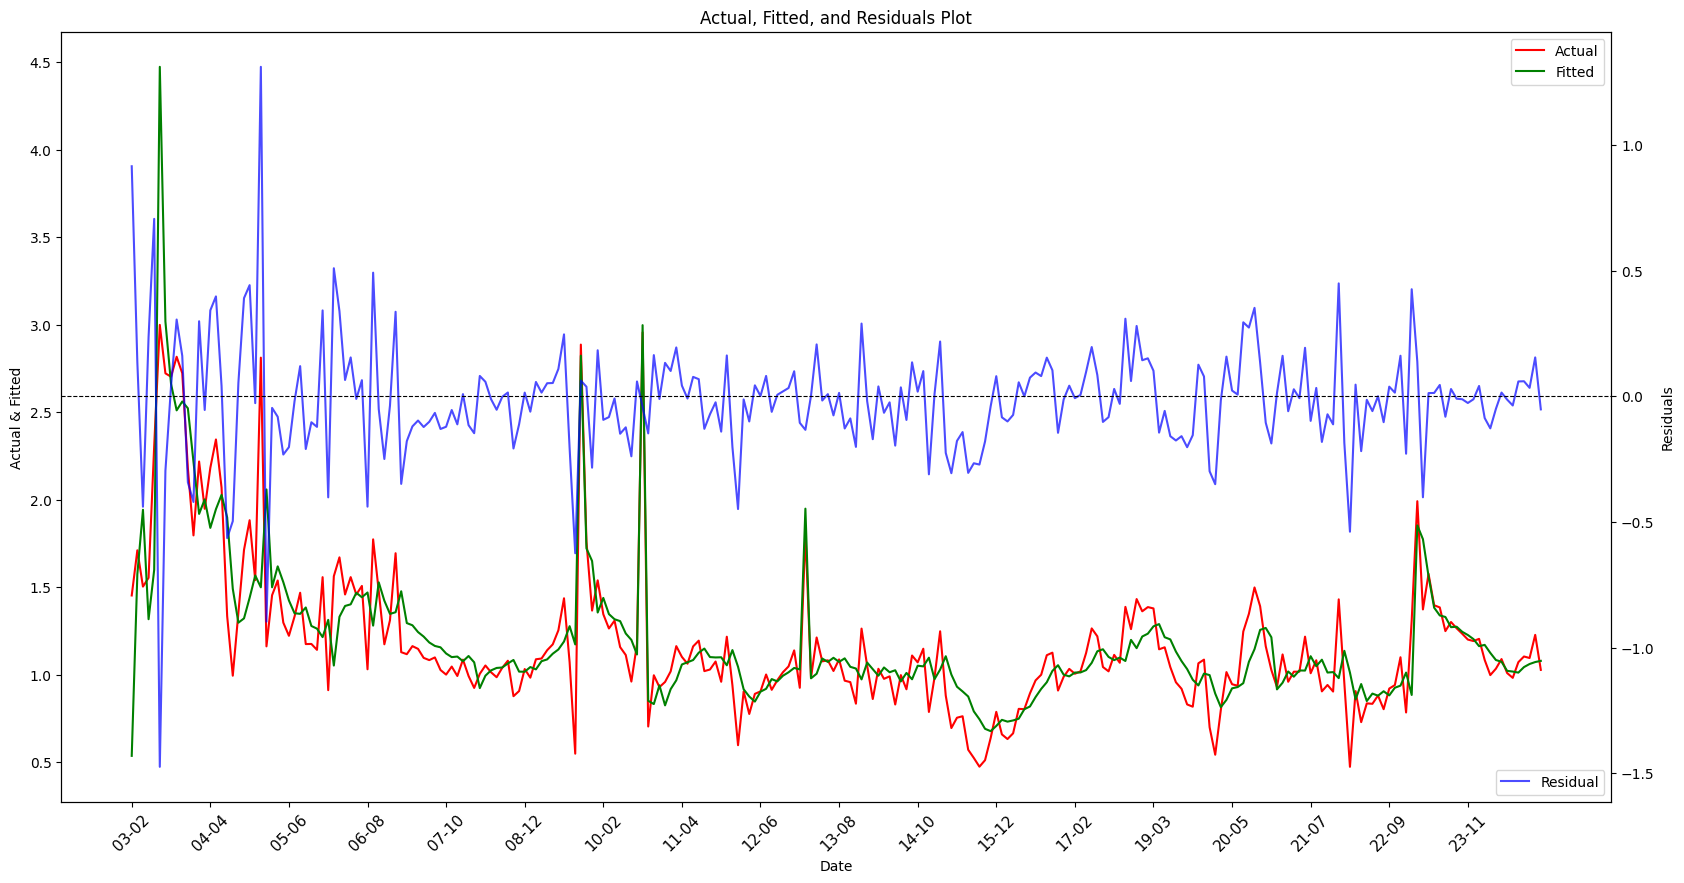

In [63]:
# Исходные данные
commodity_type = 'Chem'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 10)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("EXP_T", None)
        pval_T = results.pvalues.get("EXP_T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

Лучшие параметры SARIMAX: (9, 1, 5)
                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  252
Model:               SARIMAX(9, 1, 5)   Log Likelihood                -176.206
Date:                Fri, 21 Feb 2025   AIC                            404.411
Time:                        06:40:40   BIC                            495.124
Sample:                             0   HQIC                           440.954
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.6888      0.279     -2.472      0.013      -1.235      -0.143
X             -0.0392      0.026     -1.512      0.131      -0.090       0.012
SER0307        0

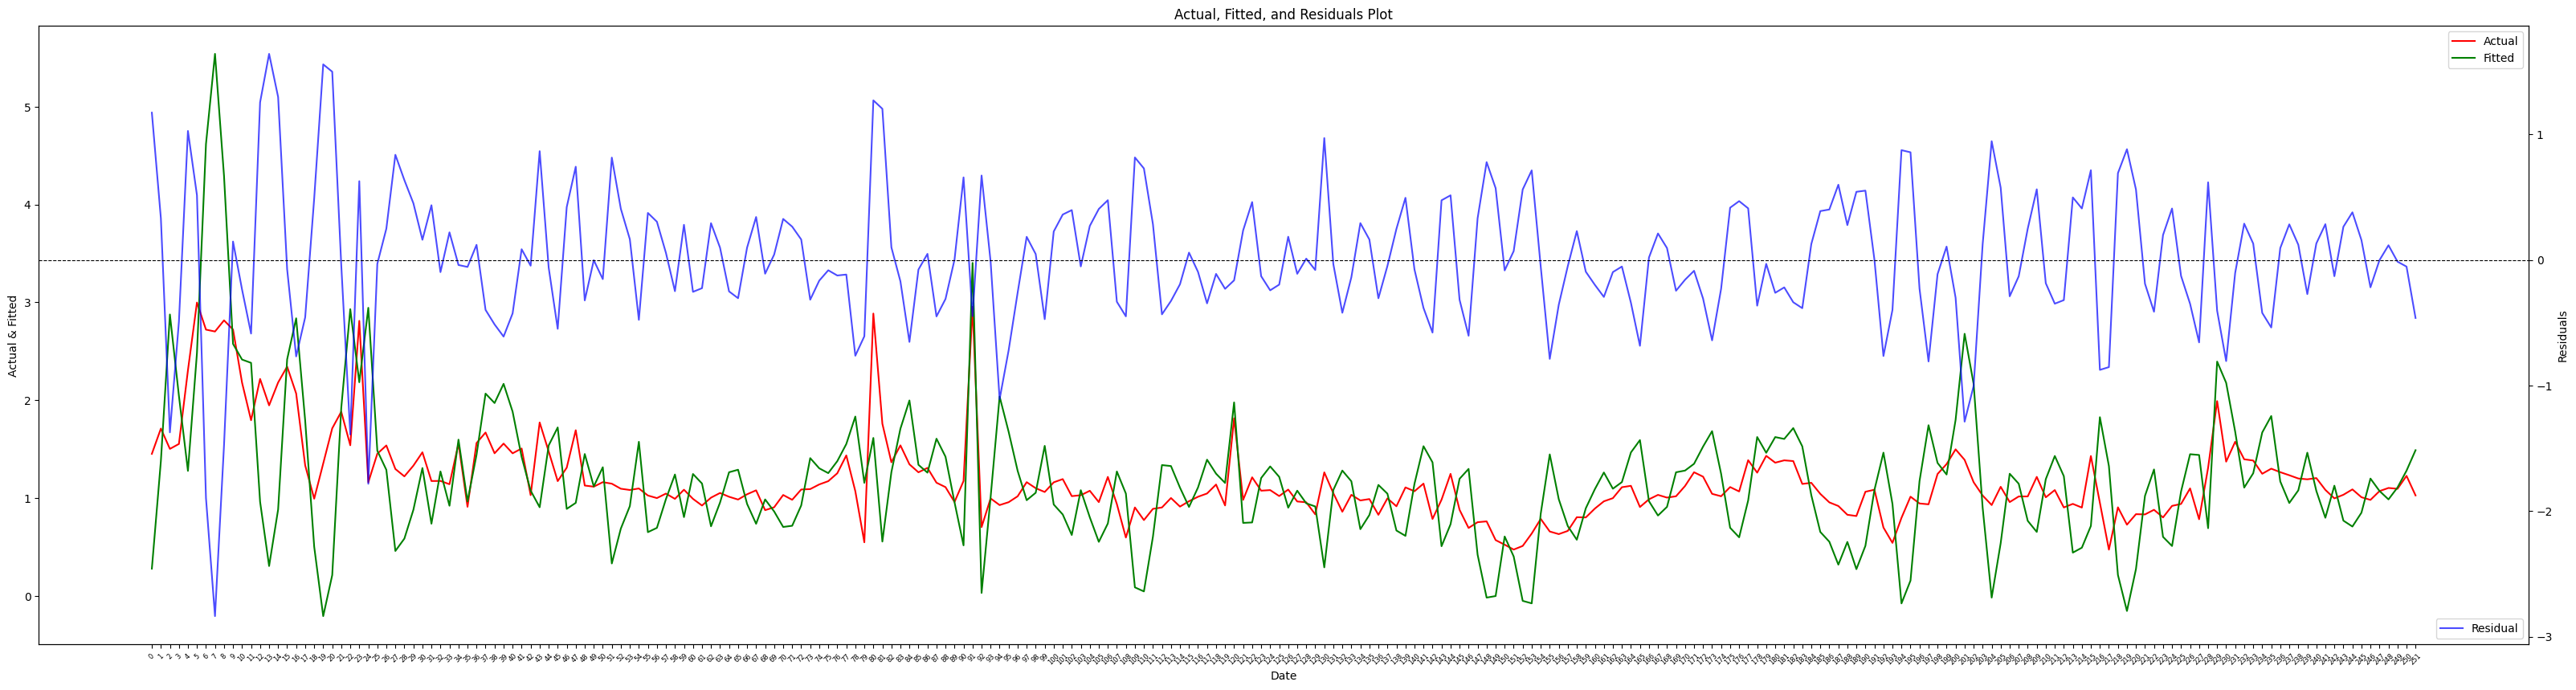

In [ ]:
# Исходные данные
commodity_type = 'Chem'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 10)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("EXP_T", None)
        pval_T = results.pvalues.get("EXP_T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.05:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

### 🐕 Fert

In [ ]:
commodity_type = 'Fert'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    #"X": df_volumes.loc[commodity_type],   # Production growth index
    #"P": df_world_prices.loc[commodity_type]   # World prices growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["Y_lag"] = df_type["Y"].shift(1)

df_type = df_type.dropna()

Y = df_type["Y"]
lst_data = [i for i in df_type.columns if i != 'Y' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]


# Вычисляем VIF для каждой переменной в X
X_vif = X.copy()  # X — это твоя матрица признаков без Y и даты
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

df_type.set_index('date', inplace=True)
# Adding a constant for regression
#X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

In [ ]:
commodity_type = 'Fert'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type],   # Production growth index
    "P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["Y_lag"] = df_type["Y"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["Y"]
X = df_type.drop(columns=["Y"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 10)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("T", None)
        pval_T = results.pvalues.get("T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

Не удалось найти подходящую модель, удовлетворяющую условиям.


In [ ]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type],   # Production growth index
    "P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Добавляем dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

# Добавляем лаг переменной Y
df_type["Y_lag"] = df_type["Y"].shift(1)

# Удаляем строки с пропущенными значениями
df_type = df_type.dropna()

# Определяем зависимую переменную
Y = df_type["Y"]

# Обязательные переменные
mandatory_features = ["T", "Y_lag"]

# Все возможные дополнительные переменные (кроме "Y" и "date")
optional_features = [col for col in df_type.columns if col not in ["Y", "date"] and col not in mandatory_features]

best_model = None
best_adj_r2 = -np.inf  # Максимизируем скорректированный R²
best_features = None

# Перебираем все возможные комбинации дополнительных признаков
flag = False
for r in tqdm(range(len(optional_features) + 1)):  # От 0 до всех возможных переменных
    for subset in itertools.combinations(optional_features, r):
        selected_features = list(mandatory_features) + list(subset)
        X = df_type[selected_features]

        # Строим регрессию
        model = sm.OLS(Y, X).fit()

        # Проверяем условия
        if model.pvalues["T"] < 0.06 and model.pvalues["Y_lag"] < 0.06 and model.params["T"] < 0:
            best_model = model
            best_features = selected_features
            flag = True
            break
            # Выбираем модель с наибольшим скорректированным R²
            # if model.rsquared_adj > best_adj_r2:
            #     best_model = model
            #     best_adj_r2 = model.rsquared_adj
            #     best_features = selected_features
    if flag:
        break
# Выводим результаты лучшей модели
if best_model:
    print("Лучшая модель:")
    print(f"Выбранные переменные: {best_features}")
    print(best_model.summary())
else:
    print("Не найдено моделей, удовлетворяющих условиям.")

In [ ]:
import itertools
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Исходные данные
commodity_type = 'Chem'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type]   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["Y_lag"] = df_type["Y"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["Y"]
X = df_type.drop(columns=["Y"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, d, q)
            best_model = results
    except:
        continue

# Вывод результатов
print(f"Лучшие параметры SARIMAX: {best_order}")
print(best_model.summary())
plot_regression_results(best_model, df_type)


In [ ]:
# from sklearn.linear_model import Ridge
# from sklearn.preprocessing import StandardScaler

# # Масштабируем признаки (Ridge чувствителен к масштабу данных)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)  # X — твоя матрица признаков без Y и даты

# # Обучаем Ridge-регрессию (альфа — параметр регуляризации)
# ridge_model = Ridge(alpha=0.01)  # Можно подобрать alpha через кросс-валидацию
# ridge_model.fit(X_scaled, Y)

# # Выводим коэффициенты
# print("Коэффициенты Ridge-регрессии:")
# print(dict(zip(X.columns, ridge_model.coef_)))

# # R² Ridge-регрессии
# print(f"R² модели: {ridge_model.score(X_scaled, Y):.4f}")

In [ ]:
# from sklearn.model_selection import GridSearchCV

# alphas = [0.01, 0.1, 1, 10, 100]
# ridge_cv = GridSearchCV(Ridge(), param_grid={"alpha": alphas}, cv=5, scoring="r2")
# ridge_cv.fit(X_scaled, Y)

# print(f"Лучший alpha: {ridge_cv.best_params_['alpha']}")

🦘 Add polynomial features

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures


# commodity_type = 'Fert'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "X": df_volumes.loc[commodity_type],   # Production growth index
#     "P": df_world_prices.loc[commodity_type]   # World prices growth index
# }

# # Добавляем дамми-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# # Добавляем лаг переменной Y
# df_type["Y_lag"] = df_type["Y"].shift(1)
# df_type = df_type.dropna()

# # Определяем зависимую и независимые переменные
# Y = df_type["Y"]
# lst_data = [i for i in df_type.columns if i not in ['Y', 'date']]
# X = df_type[lst_data]

# # Добавляем полиномиальные признаки (кроме дамми)
# poly = PolynomialFeatures(degree=2, include_bias=False)
# numeric_features = ["T", "P", "Y_lag"]  # Можно выбрать другие фичи
# X_poly = poly.fit_transform(X[numeric_features])

# # Создаем новый датафрейм с полиномами
# X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(numeric_features), index=X.index)

# # Добавляем дамми-переменные обратно
# X_final = pd.concat([X_poly_df, X.drop(columns=numeric_features)], axis=1)

# # Добавляем константу
# #X_final = sm.add_constant(X_final)
# # Вычисляем VIF для каждой переменной в X
# X_vif = X_final.copy()  # X — это твоя матрица признаков без Y и даты
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_vif.columns
# vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

# print(vif_data)
# # Обучаем регрессию
# model = sm.OLS(Y, X_final).fit()

# print("**********************************************************************************")
# print("commodity type:", commodity_type)

# # Выводим результаты
# plot_regression_results(model, df_type)
# print(model.summary())

🐗 Add log data

In [ ]:
import statsmodels.api as sm

commodity_type = 'Fert'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    #"X": df_volumes.loc[commodity_type],   # Production growth index
    #"P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Добавляем дамми-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

# Добавляем лаг переменной Y
# df_type["Y_lag"] = df_type["Y"].shift(1)

# Удаляем строки с пропущенными значениями
df_type = df_type.dropna()

# Логарифмируем переменные (только положительные значения!)
log_features = ["Y", "T"]
for col in log_features:
    df_type[col] = np.log(df_type[col])

# Определяем зависимую и независимые переменные
Y = df_type["Y"]
X = df_type.drop(columns=["Y", "date"])  # Исключаем Y и дату
# Adding a constant for regression
#X = sm.add_constant(X)
# Вычисляем VIF для каждой переменной в X
X_vif = X.copy()  # X — это твоя матрица признаков без Y и даты
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)
# Обучаем регрессию без константы
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)
plot_regression_results(model, df_type)
print(model.summary())


### 🐳 nFerr

**********************************************************************************
commodity type: nFerr


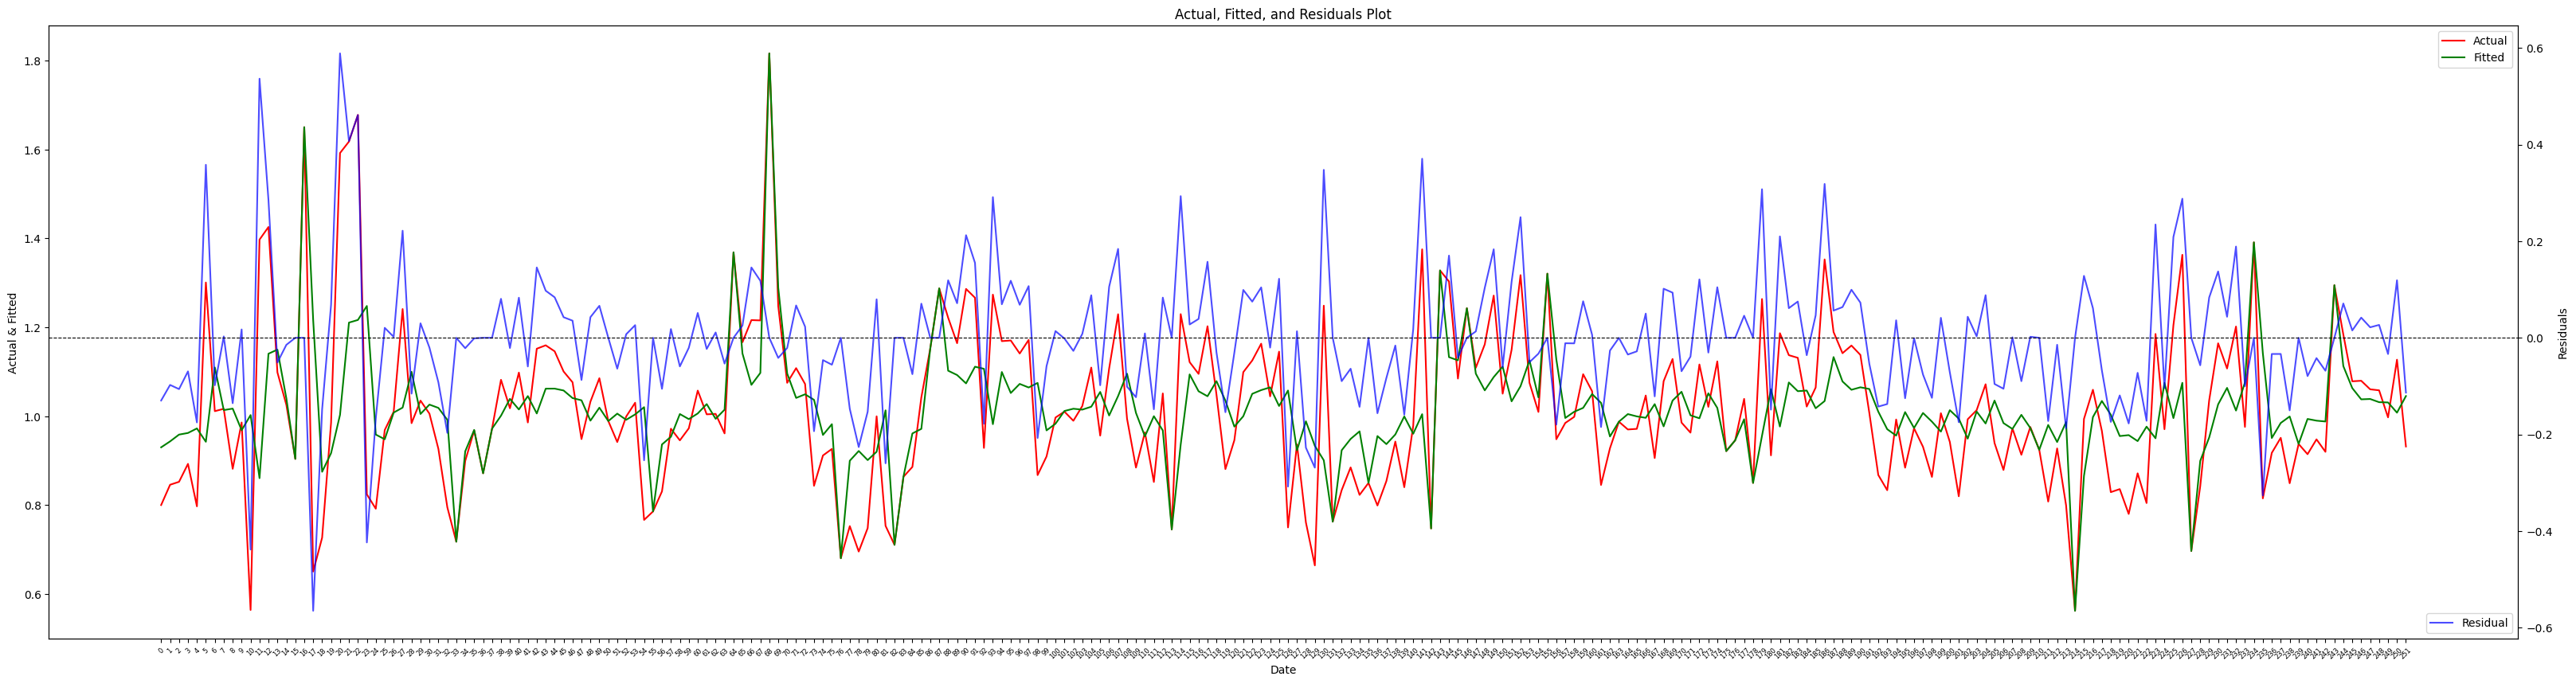

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     4.519
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           3.29e-12
Time:                        09:40:25   Log-Likelihood:                 132.04
No. Observations:                 252   AIC:                            -194.1
Df Residuals:                     217   BIC:                            -70.54
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7309      0.297      2.459      0.0

In [ ]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type],   # Production growth index
    "P": df_world_prices.loc[commodity_type]   # World prices growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["Y_lag"] = df_type["Y"].shift(1)

df_type = df_type.dropna()

Y = df_type["Y"]
lst_data = [i for i in df_type.columns if i != 'Y' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]
df_type.set_index('date', inplace=True)
# Adding a constant for regression
X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

In [ ]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type],   # Production growth index
    "P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["Y_lag"] = df_type["Y"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["Y"]
X = df_type.drop(columns=["Y"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 20)
d_values = range(0, 10)
q_values = range(0, 20)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("T", None)
        pval_T = results.pvalues.get("T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

In [ ]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type],   # Production growth index
    "P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Добавляем dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

# Добавляем лаг переменной Y
df_type["Y_lag"] = df_type["Y"].shift(1)

# Удаляем строки с пропущенными значениями
df_type = df_type.dropna()

# Определяем зависимую переменную
Y = df_type["Y"]

# Обязательные переменные
mandatory_features = ["T", "Y_lag"]

# Все возможные дополнительные переменные (кроме "Y" и "date")
optional_features = [col for col in df_type.columns if col not in ["Y", "date"] and col not in mandatory_features]

best_model = None
best_adj_r2 = -np.inf  # Максимизируем скорректированный R²
best_features = None

# Перебираем все возможные комбинации дополнительных признаков
for r in tqdm(range(len(optional_features) + 1)):  # От 0 до всех возможных переменных
    for subset in itertools.combinations(optional_features, r):
        selected_features = list(mandatory_features) + list(subset)
        X = df_type[selected_features]

        # Строим регрессию
        model = sm.OLS(Y, X).fit()

        # Проверяем условия
        #if model.pvalues["T"] < 0.1 and model.pvalues["Y_lag"] < 0.1 and model.params["T"] < 0:
        if model.params["T"] < 0:
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X.columns
            vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            print(vif_data)
            best_model = model
            best_features = selected_features
            flag = True
            break
            # Выбираем модель с наибольшим скорректированным R²
            # if model.rsquared_adj > best_adj_r2:
            #     best_model = model
            #     best_adj_r2 = model.rsquared_adj
            #     best_features = selected_features
    if best_model:
        break
# Выводим результаты лучшей модели
if best_model:
    print("Лучшая модель:")
    print(f"Выбранные переменные: {best_features}")
    print(best_model.summary())
else:
    print("Не найдено моделей, удовлетворяющих условиям.")